## Solution for [12/9/22 "Riddler Classic"](https://fivethirtyeight.com/features/can-you-win-the-riddler-football-playoff/)


>The Riddler Football Playoff (RFP) consists of four teams. Each team is assigned a random real number between 0 and 1, representing the “quality” of the team. If team A has quality a and team B has quality b, then the probability that team A will defeat team B in a game is $a/(a+b)$.
>
>In the semifinal games of the playoff, the team with the highest quality (the “1 seed”) plays the team with the lowest quality (the “4 seed”), while the other two teams play each other as well. The two teams that win their respective semifinal games then play each other in the final.
>
>On average, what is the quality of the RFP champion?

I *think* this problem should be solvable using geometric arguments:
* The set of numbers $0 \leq d < c < b < a \leq 1$ defines a shape in the unit hypercube.
* Do something like integrating the area between its projection onto the $(a, d)$ and $(b, c)$ spaces and the curve $a/(a+d)$ and $b/(b+c)$
* Repeat somehow to get to the intersection of the two?

But, I couldn't see all the way through that approach.  Anyways, it's easy to do programattically...

In [1]:
import numpy as np

N = int(1e8)  # samples of this size take a few minutes to run on my laptop, but make the ultimate plots pretty

# probably could do this with a 2D call to uniform() from the start, but whatever
a, b, c, d = [ np.random.uniform(size=N) for i in range(4) ]
cols = np.column_stack([a, b, c, d])
d, c, b, a = np.moveaxis(np.take_along_axis(cols, np.argsort(cols, axis=1), axis=1), 1, 0)  # make sure a, b, c, d are always ranked in order

# do the semifinals
a_prob = a / (a + d)
b_prob = b / (b + c)
mask = np.random.uniform(size=N)
semi1 = (mask < a_prob) * a + (mask > a_prob) * d   # this is the quality of the winner of semifinal 1
semi2 = (mask < b_prob) * b + (mask > b_prob) * c   # and similarly for semifinal 2

# now do the finals 
mask =  np.random.uniform(size=N)
semi1_prob = semi1 / (semi1 + semi2)
final = (mask < semi1_prob) * semi1 + (mask > semi1_prob) * semi2   # this is the quality of the victor in the finals

print("Average quality of victor =", np.mean(final))

Average quality of victor = 0.6623901921911969


## Demonstration plots

Everything that follows is just to make some nice plots to show that the results look sensible.

This first cell is just to centralize the plotting tools

In [2]:
# shared plotting tools.
# actual plots in following cells

import matplotlib
matplotlib.rcParams["font.size"] = 15
matplotlib.rc("text", usetex=False)

from matplotlib import pyplot as plt

FIG_CONFIG = {
    "figsize": (10, 8),
    "facecolor": "white",
}

HIST_CONFIG = {
    "bins": 500,
    "range": (0, 1),
    "alpha": 0.4,
    "density": True,
    "histtype": "stepfilled",
    "linewidth": 1,
}

# borrowed from https://stackoverflow.com/q/37765197
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def plot_distributions(dists, fig_config={}, hist_config={}):
    fig, ax = plt.subplots(1, **fig_config)

    mean_points = {}
    colors = {}
    for name, quals in dists:
        # this plots the histograms...

        mean = np.mean(quals)
        freqs, bins, patches = ax.hist(quals, label=name, **hist_config)

        # the remainder is all just to put a slightly darker vertical line at the mean value
        diffs = np.abs(bins - mean)
        closest_xbin = np.argmin(diffs)
        next_closest_xbin = closest_xbin + 1
        if closest_xbin > 0 and (next_closest_xbin > len(bins) - 1 or diffs[closest_xbin - 1] < diffs[next_closest_xbin]):
            next_closest_xbin = closest_xbin - 1
        first, second = sorted([closest_xbin, next_closest_xbin])
        colors[name] = adjust_lightness(patches[0].get_facecolor(), 0.85)
        ax.fill_between(x=(bins[first], bins[second]), y1=0, y2=freqs[second], step="post", color=colors[name])
        mean_points[name] = (mean, freqs[second])

    ax.set_xlabel("Quality")
    ax.set_ylabel("Probability density")

    return fig, mean_points, colors

def draw_annotations(means, offsets, colors={}):
    for team, mean in means.items():
        arrow_rad = ""
        adj = offsets[team]
        if adj[0] != 0:
            arrow_rad = ",rad=" + ("-" if adj[0] < 0 else "") + "0.2"
        args = dict(text=" ".join([r"$\bf{{{0}}}$".format(s) for s in team.split()]) + "\nmean={:.2f}".format(mean[0]), ha="center",
                     xy=mean, xycoords="data",
                     xytext=np.array(mean) + np.array(adj), textcoords="data",
                     arrowprops=dict(arrowstyle="-|>",
                                     connectionstyle="arc3" + arrow_rad,
                                     shrinkB=5,
                                     fc="w"))
        if team in colors:
            args["color"] = colors[team]
            args["arrowprops"]["color"] = colors[team]
        plt.annotate(**args)


### "Quality" distributions for the four teams

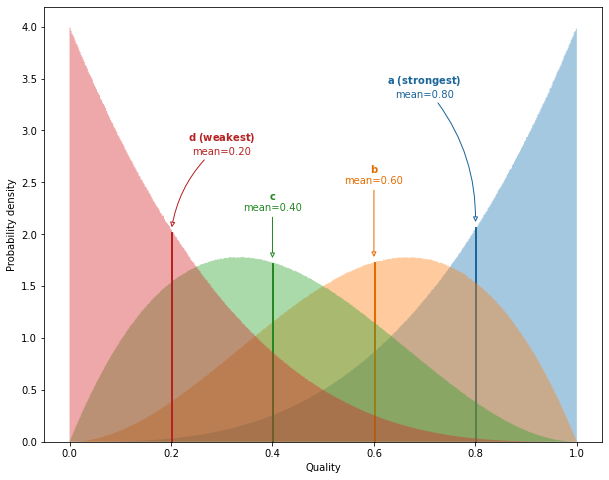

In [3]:
# Plot showing the input "quality" distributions

fig, mean_points, colors = plot_distributions([("a (strongest)", a), ("b", b), ("c", c), ("d (weakest)", d)],
                                              fig_config=FIG_CONFIG,
                                              hist_config=HIST_CONFIG)

# we need to do these annotations manually anyway
# (too hard to do programmatically)
adjust = {"a (strongest)": (-0.1, +1.25),
          "b": (0, +0.75),
          "c": (0, +0.5),
          "d (weakest)": (0.1, +0.75)}
draw_annotations(mean_points, adjust, colors)


plt.show()

### "Quality" distributions for the semifinal winners & ultimate champion

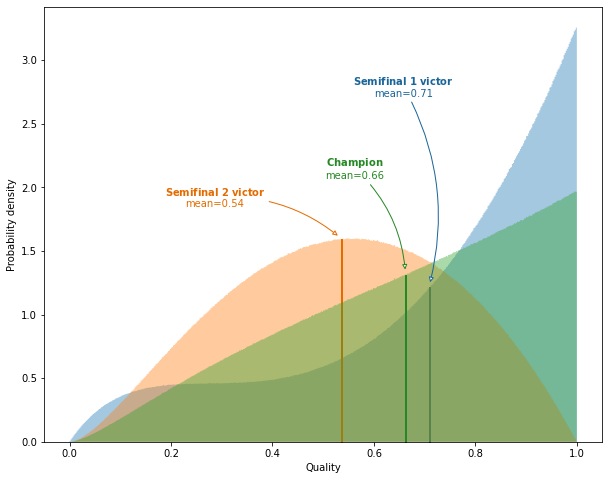

In [4]:
# Plot showing the "quality" distributions of the semifinal winners & ultimate champion

fig, mean_points, colors = plot_distributions( [("Semifinal 1 victor", semi1), ("Semifinal 2 victor", semi2), ("Champion", final)],
                                               fig_config=FIG_CONFIG,
                                               hist_config=HIST_CONFIG)

adjust = {"Semifinal 1 victor": (-0.05, 1.5),
          "Semifinal 2 victor": (-0.25, +0.25),
          "Champion": (-0.1, +0.75)}
draw_annotations(mean_points, adjust, colors)
plt.show()